In [1]:
import osmnx as ox
import random 

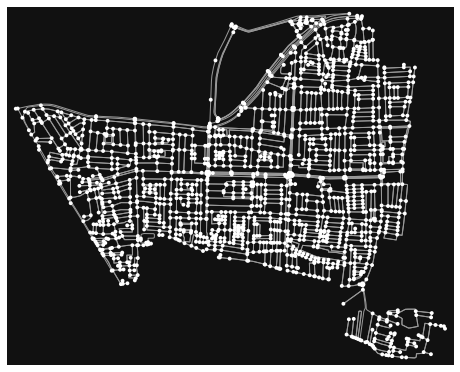

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [11]:
ox.plot_graph(ox.graph_from_place("HSR,Bengaluru,India"))

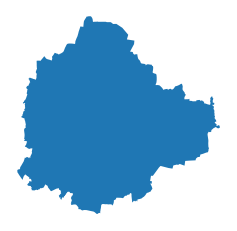

In [14]:
city = ox.geocode_to_gdf('Bengaluru, India')
ax = ox.project_gdf(city).plot()
_ = ax.axis('off')

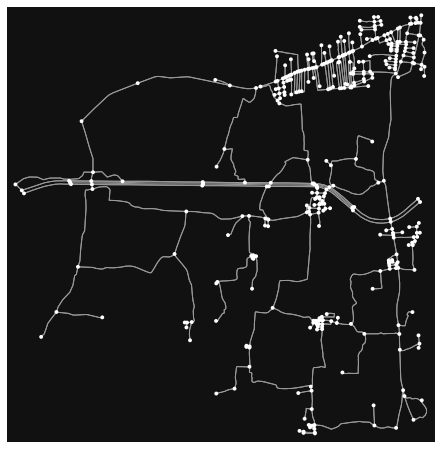

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [19]:
G = ox.graph_from_point((13,77),dist=3000,network_type='all')
ox.plot_graph(G)

### Genetic Algorithm and Osmnx

In [3]:
# Define the source and destination
start = (12.903190, 77.648579)  # Start point (latitude, longitude)
end = (12.920170, 77.665408)   # End point (latitude, longitude)

In [4]:
# Define the fitness function
def fitness(solution):
    # Calculate the distance between start and end points
    distance = ox.distance.euclidean_dist_vec(start[1], start[0], end[1], end[0])
    
    # Calculate the distance of the path and penalize solutions that do not follow roads or paths
    path_distance = 0
    for i in range(len(solution) - 1):
        u, v, key = solution[i], solution[i+1], 0
        if 'key' in G.edges[u, v]:
            key = G.edges[u, v]['key']
        path_distance += G.edges[u, v, key]['length']
    penalty = 0
    for i in range(len(solution) - 1):
        u, v, key = solution[i], solution[i+1], 0
        if 'key' in G.edges[u, v]:
            key = G.edges[u, v]['key']
        if 'foot' not in G.edges[u, v, key]['highway'] and 'path' not in G.edges[u, v, key]['highway']:
            penalty += 1000
    return 1/(path_distance + penalty + 0.00001)

In [5]:
# Define the genetic algorithm parameters
POPULATION_SIZE = 100
MUTATION_RATE = 0.1
CROSSOVER_RATE = 0.5
GENERATIONS = 50

In [9]:
# Initialize the population
G = ox.graph.graph_from_point(start, dist=1000, network_type='walk')
nodes = list(G.nodes())
population = [random.sample(nodes, len(nodes)) for i in range(POPULATION_SIZE)]

In [11]:
# Implementing the genetic algorithm
for generation in range(GENERATIONS):
    # Evaluate the fitness of each solution
    fitness_scores = [fitness(solution) for solution in population]
    # Select parents for the next generation
    parents = []
    for i in range(POPULATION_SIZE):
        candidate1, candidate2 = random.choices(population, weights=fitness_scores, k=2)
        parents.append((candidate1, candidate2))
    # Apply crossover and mutation to create new solutions
    children = []
    for parent1, parent2 in parents:
        if random.random() < CROSSOVER_RATE:
            crossover_point = random.randint(1, len(nodes) - 2)
            child = parent1[:crossover_point] + parent2[crossover_point:]
        else:
            child = parent1
        if random.random() < MUTATION_RATE:
            mutation_point1 = random.randint(0, len(nodes) - 1)
            mutation_point2 = random.randint(0, len(nodes) - 1)
            child[mutation_point1], child[mutation_point2] = child[mutation_point2], child[mutation_point1]
        children.append(child)
    # Evaluate the fitness of the new solutions
    child_fitness_scores = [fitness(solution) for solution in children]
    # Select the best solution from the final population
    best_solution = population[fitness_scores.index(max(fitness_scores))]
    # Set the population to the new generation
    population = children

ValueError: not enough values to unpack (expected 3, got 2)

In [ ]:
# Plot the path using OSMnx
best_path = ox.plot_route_folium(G, best_solution, popup_attribute=None)